In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [3] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 42.449 MiB


# Ideal Point Estimation

Here we perform Ideal Point Estimation of legislators in 113th Congress.

## Load Data
### Legislators
First we have to load in all legislators (this is for all of time, from GovTrack).

In [4]:
import ideal_point.raw_data

In [4] used 32.953 MiB RAM in 1.448s, peaked 0.000 MiB above current, total RAM usage 75.402 MiB


In [5]:
legislator_df = ideal_point.raw_data.legislators()
legislator_df.head()

,last_name,first_name,birthday,gender,type,state,district,party,url,address,...,thomas_id,opensecrets_id,lis_id,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,1952-11-09,M,sen,OH,NaN,Democrat,https://www.brown.senate.gov,713 Hart Senate Office Building Washington DC ...,...,136.0,N00003535,S307,5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,1958-10-13,F,sen,WA,NaN,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,...,172.0,N00007836,S275,26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,1943-10-05,M,sen,MD,NaN,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,...,174.0,N00001955,S308,4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,1947-01-23,M,sen,DE,NaN,Democrat,http://www.carper.senate.gov,513 Hart Senate Office Building Washington DC ...,...,179.0,N00012508,S277,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,1960-04-13,M,sen,PA,NaN,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,...,1828.0,N00027503,S309,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [5] used 10.180 MiB RAM in 0.236s, peaked 2.141 MiB above current, total RAM usage 85.582 MiB


### Votes

Next we can load in all the votes. We get two dataframes from this, `vote_df` and `position_df`.

Each row of `vote_df` corresponds to one roll call vote (like on the passage of a bill).

Each row of `position_df` corresponds to one legislators position on a vote.

In [6]:
vote_df, position_df = ideal_point.raw_data.votes(legislator_df)


In [6] used 196.160 MiB RAM in 292.140s, peaked 26.590 MiB above current, total RAM usage 281.742 MiB


In [7]:
vote_df.head()

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,record_modified,requires,result,result_text,session,source_url,subject,type,updated_at,vote_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,quorum,h,...,NaN,QUORUM,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll001.xml,NaN,Call of the House,2014-06-18T11:22:24-04:00,h1-113.2013
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll010.xml,NaN,On the Motion to Adjourn,2014-06-18T11:22:23-04:00,h10-113.2013
2,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,recommit,h,...,NaN,1/2,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll100.xml,Preventing Greater Uncertainty in Labor-Manage...,On the Motion to Recommit,2014-06-18T11:22:04-04:00,h100-113.2013
3,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,passage,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll101.xml,Preventing Greater Uncertainty in Labor-Manage...,On Passage of the Bill,2014-06-18T11:22:04-04:00,h101-113.2013
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,procedural,h,...,NaN,1/2,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll102.xml,NaN,On Approving the Journal,2014-06-18T11:22:04-04:00,h102-113.2013


In [7] used 0.191 MiB RAM in 0.050s, peaked 0.000 MiB above current, total RAM usage 281.934 MiB


In [8]:
position_df.head()

,legislator_index,position,vote_index
0,39,Present,0
1,12270,Present,0
2,40,Present,0
3,376,Present,0
4,12276,Present,0


In [8] used 0.000 MiB RAM in 0.026s, peaked 0.000 MiB above current, total RAM usage 281.934 MiB


## Transform Data

Next we have to transform our data to a format we can train our model on.

Our observed data is basically `position_df`. but instead of categorical `position`s, we need them to
be 1s and 0s. Also, since we aren't using all of the legislators, we need to transform
the `legislator_index` into a relative index. We call this transformed dataframe `model_position_df`.

In [9]:
import ideal_point.ideal_point

In [9] used 9.730 MiB RAM in 1.581s, peaked 0.000 MiB above current, total RAM usage 291.664 MiB


In [10]:
model_position_df, model_legislator_index, model_vote_index = ideal_point.ideal_point.transform_data(position_df, vote_df, legislator_df)

In [10] used 23.309 MiB RAM in 1.477s, peaked 75.188 MiB above current, total RAM usage 314.973 MiB


In [11]:
model_position_df.head()

,legislator,position,vote
0,39,0,0
1,530,0,0
2,40,0,0
3,375,0,0
4,0,0,0


In [11] used 0.000 MiB RAM in 0.011s, peaked 0.000 MiB above current, total RAM usage 314.973 MiB


In [12]:
model_position_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508555 entries, 0 to 508554
Data columns (total 3 columns):
legislator    508555 non-null int64
position      508555 non-null int64
vote          508555 non-null int64
dtypes: int64(3)
memory usage: 11.6 MB
In [12] used 0.012 MiB RAM in 0.031s, peaked 0.000 MiB above current, total RAM usage 314.984 MiB


The two series `model_legislator_index` and `model_vote_index` map the values in `model_position_df` to the full dataframes, from index to value.

## Create Model

Now we can create our model, given we have observed those votes. The notation is based
on ["Comparing NOMINATE and IDEAL: Points of Difference and Monte Carlo Tests"](http://scholar-qa.princeton.edu/sites/default/files/jameslo/files/lsq_nomvsideal.pdf).

In [13]:
import ideal_point.gradient

In [13] used 0.008 MiB RAM in 0.024s, peaked 0.000 MiB above current, total RAM usage 314.992 MiB


In [14]:
g = ideal_point.gradient.Gradient(model_position_df)

In [14] used 876.410 MiB RAM in 4.620s, peaked 0.000 MiB above current, total RAM usage 1191.402 MiB


In [15]:
g.n_legislators, g.n_votes

(548, 1446)

In [15] used 0.195 MiB RAM in 0.019s, peaked 0.000 MiB above current, total RAM usage 1191.598 MiB


## Train Model

Now we can run variational inference to compute estimated parameters for the model.

In [16]:
# g.run(1000)
# params = g.params
# ideal_point.ideal_point.save_params(params)

In [16] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 1191.598 MiB


Or load it from disk, if we have already computed it (takes about an hour and a half on my computer)

In [17]:
params = ideal_point.ideal_point.load_params()

In [17] used 0.000 MiB RAM in 0.032s, peaked 0.000 MiB above current, total RAM usage 1191.598 MiB


## Integrate Data

Now we can integrate the parameters we learned backed info our `vote_df` and `legislator_df`. We add a `ideology` column to both of them and filter out rows without ideal points. We also add a `bias` to the votes (which is greater if any senator is more likely to vote yes).

In [18]:
legislators_pt_df = ideal_point.ideal_point.leg_add_ideology(legislator_df, model_legislator_index, g.params)
vote_pt_df = ideal_point.ideal_point.vote_add_ideology_and_bias(vote_df, model_vote_index, g.params)

In [18] used 6.031 MiB RAM in 0.089s, peaked 0.000 MiB above current, total RAM usage 1197.629 MiB


### Visualize Points

We can do a quick gut chuck of our legislator ideal points to make sure they seperate democrats and republicans

In [19]:
from altair import *

In [19] used 0.004 MiB RAM in 0.233s, peaked 0.000 MiB above current, total RAM usage 1197.633 MiB


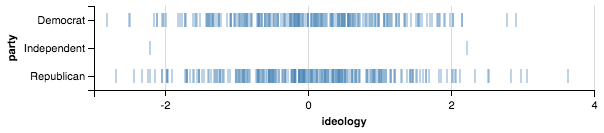

In [20] used 0.059 MiB RAM in 0.102s, peaked 0.000 MiB above current, total RAM usage 1197.691 MiB


In [20]:
Chart(legislators_pt_df[["ideology", "party"]]).mark_tick().encode(
    x='ideology:Q',
    y='party:O',
)

In [21]:
vote_pt_df.head()

,amendment_author,amendment_number,amendment_purpose,amendment_type,bill_congress,bill_number,bill_title,bill_type,category,chamber,...,result,result_text,session,source_url,subject,type,updated_at,vote_id,bias,ideology
2,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,recommit,h,...,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll100.xml,Preventing Greater Uncertainty in Labor-Manage...,On the Motion to Recommit,2014-06-18T11:22:04-04:00,h100-113.2013,0.482782,-1.607644
3,NaN,NaN,NaN,NaN,113.0,1120.0,NaN,hr,passage,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll101.xml,Preventing Greater Uncertainty in Labor-Manage...,On Passage of the Bill,2014-06-18T11:22:04-04:00,h101-113.2013,-1.768579,-0.983603
5,NaN,NaN,NaN,NaN,113.0,1162.0,NaN,hr,passage-suspension,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll103.xml,"To amend title 31, United States Code, to make...","On Motion to Suspend the Rules and Pass, as Am...",2014-06-18T11:22:04-04:00,h103-113.2013,0.528306,-1.859815
6,NaN,NaN,NaN,NaN,113.0,882.0,NaN,hr,passage-suspension,h,...,Passed,Passed,2013,http://clerk.house.gov/evs/2013/roll104.xml,To prohibit the awarding of a contract or gran...,"On Motion to Suspend the Rules and Pass, as Am...",2014-06-18T11:22:04-04:00,h104-113.2013,-1.160088,-0.468471
7,NaN,NaN,NaN,NaN,113.0,249.0,NaN,hr,passage-suspension,h,...,Failed,Failed,2013,http://clerk.house.gov/evs/2013/roll105.xml,"To amend title 5, United States Code, to provi...",On Motion to Suspend the Rules and Pass,2014-06-18T11:22:04-04:00,h105-113.2013,-0.384874,-0.277965


In [21] used 0.000 MiB RAM in 0.058s, peaked 0.000 MiB above current, total RAM usage 1197.691 MiB


### Validation

Some of the most conservative members in our model include Mike Pompeo, who lead the house inquiry into Benghazi, and Randy Weber, who drew fire for a tweet declaring Barack Obama a "socialist dictator."

Some of the most liberal members include Jim McGovern, who represents the pioneer valley and Jerrold Nadler, who represents Manhattan's upper west side. The most liberal legislator, Jan Schakowsky, is a longtime critic of the Iraq war.

The house bills to remove voted on by all democrats are close to the democratic ideology.

In [22]:
# pd.set_option('display.max_columns', 999)
# pd.set_option('display.max_colwidth', 200)
# vote_pt_df[vote_pt_df["question"].str.contains("Immigration", na=False)]
# vote_pt_df[vote_pt_df["number"] == 168]

In [22] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 1197.691 MiB


In [23]:
labels = pd.Series([
    "Violence Against Women Reauthorization Act of 2013",
    "Border Security, Economic Opportunity, and Immigration Modernization Act",
    "Keystone XL Pipeline Approval Act",
    "Consolidated Appropriations Act, 2014"
], index=[
    500,
    717,
    76,  
    570
])

NameError: name 'pd' is not defined

In [23] used 0.000 MiB RAM in 0.269s, peaked 0.000 MiB above current, total RAM usage 1197.691 MiB


In [ ]:
chart_df = vote_pt_df[["ideology", "bias"]].assign(bill=labels).dropna()

In [ ]:
Chart(chart_df).mark_text().encode(
    x='ideology:Q',
    y='bias:Q',
    text='bill',
)

In [ ]:
Chart(vote_pt_df[["ideology", "bias"]].dropna()).mark_circle().encode(
    x='ideology:Q',
    y='bias:Q',)

This is to get bills linked w/ duplication data for now

## Text reuse

In [ ]:
# vote_pt_df.to_csv("vote_pt_df.csv")
# run wtfpandasjoin.py to do the join. i kept trying to do w/ pandas and getting errors/bugs

In [17]:
import pandas as pd
import math
reuse_df = pd.DataFrame.from_csv("pairs_enhanced_again.txt")
# many, many, many unknowns b.c no votes. research opportunity. ideal point w/o vote. interesting... b/c many
# things are killed in committee. 
criterion = reuse_df['ideology_a'].map(lambda x: x != "unknown") 
reuse_df_no_unk = reuse_df[criterion]
reuse_df_no_unk['ideology_a'] = reuse_df_no_unk['ideology_a'].astype(float)
reuse_df_no_unk['ideology_a'] = reuse_df_no_unk['ideology_b'].astype(float)
reuse_df_no_unk['ideology_eq'] = reuse_df_no_unk.apply(lambda x:x["ideology_a"] == x["ideology_b"], axis=1)
reuse_df_no_unk = reuse_df_no_unk[reuse_df_no_unk['ideology_eq'] == False]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


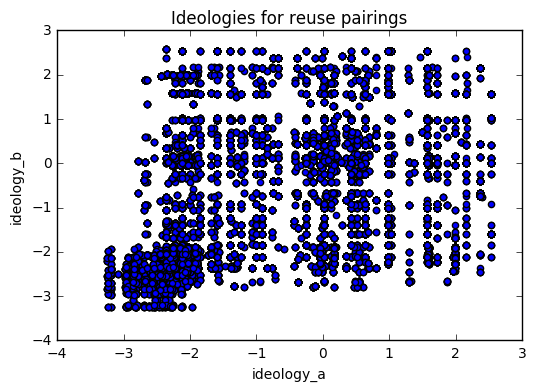

In [55]:
%matplotlib inline
# http://stackoverflow.com/questions/14300137/making-matplotlib-scatter-plots-from-dataframes-in-pythons-pandas
import matplotlib.pylab as plt

reuse_df_no_unk.plot(kind='scatter', x='ideology_a', y='ideology_b', title="Ideologies for reuse pairings")

#### Bipartisanship?

It appears that a liberal section 

In [ ]:
import pandas as pd
import math
reuse_df = pd.DataFrame.from_csv("pairs_enhanced_again.txt")
# many, many, many unknowns b.c no votes. research opportunity. ideal point w/o vote. interesting... b/c many
# things are killed in committee. 
criterion = reuse_df['ideology_a'].map(lambda x: x != "unknown") 
reuse_df_no_unk = reuse_df[criterion]
reuse_df_no_unk["sa"] = reuse_df_no_unk["ideology_a"].astype(float)> 0
reuse_df_no_unk["sb"] = reuse_df_no_unk["ideology_b"].astype(float)> 0
reuse_df_no_unk["diff"] = reuse_df_no_unk["sa"] == reuse_df_no_unk["sb"]
c2 = reuse_df_no_unk["diff"].map(lambda x: x == False) 
reuse_df_no_unk = reuse_df_no_unk[c2]
reuse_df_no_unk.shape